In [120]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import numpy as np
import torch
import pandas as pd
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

# Problem setup

We solve the simpler problem where we search for a sparse set of dictionary items $d_i$ that sum up to a given signal $s$ as

$$
s=\sum\limits_i\alpha_id_i,\,\|\alpha\|_0\to\min
$$

We use model data with a random signal from sine waves, and we want to decompose it into a Fourier basis. We try two methods:

1. $l_1$ regularization. Here we just relax the problem to $\|\alpha\|_1\to\min$ and solve a regularized equation $\|s-\alpha_id_i\|_2^2+q\|\alpha\|_1\to\min$. This is lasso linear regression
2. Matching pursuit. Here we use the algorithm that greedely calculates the best matching dictionary element using the scalar product, and then adds it to the decomposition.

We compare the resulting $l_0$-sparsity of the two solutions and their efficiency

Dictionary shape (60, 100)


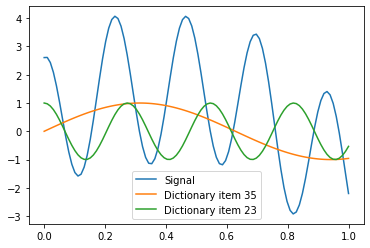

In [256]:
x = np.linspace(0, 1, 100)
frequencies = np.arange(0, 30)
args = np.repeat(frequencies[:, np.newaxis], len(x), axis=1)
args = np.multiply(x, args)

# the dictionary
D = np.vstack((np.cos(args), np.sin(args)))
print("Dictionary shape", D.shape)

# the signal
n_sig = 3
sig_coeff = np.random.randn(n_sig) + 1
sig_item = np.random.choice(len(D), n_sig, replace=False)
signal = np.dot(sig_coeff, D[sig_item, :])

plt.figure()
plt.plot(x, signal, label="Signal")
for _ in range(2):
    idx = np.random.choice(len(D))
    plt.plot(x, D[idx, :], label=f"Dictionary item {idx}")
plt.legend()
plt.show()

In [257]:
# converting to pytorch
Dt = torch.tensor(D, dtype=torch.float32)
st = torch.tensor(signal, dtype=torch.float32)

# $l_1$-regularization

In [258]:
# the coefficient
alpha = torch.nn.Linear(in_features=len(D), out_features=1, bias=False)
aw = list(alpha.parameters())[0]
opt = torch.optim.Adam(alpha.parameters())
q = 1e-3

In [259]:
for _ in tqdm(range(50000)):
    opt.zero_grad()
    loss = torch.nn.MSELoss()(alpha(Dt.T).flatten(), st) + q * torch.norm(aw.flatten(), p=1)
    loss.backward()
    opt.step()
loss

tensor(0.0046, grad_fn=<AddBackward0>)

In [260]:
awnp = aw.detach().numpy()

<AxesSubplot:>

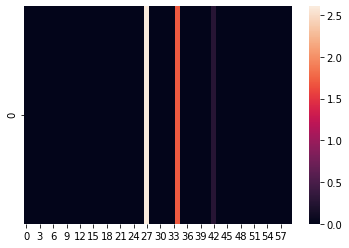

In [261]:
sns.heatmap(awnp)

(array([57.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([-8.1227883e-04,  2.5972199e-01,  5.2025622e-01,  7.8079051e-01,
         1.0413247e+00,  1.3018590e+00,  1.5623933e+00,  1.8229276e+00,
         2.0834618e+00,  2.3439960e+00,  2.6045303e+00], dtype=float32),
 <BarContainer object of 10 artists>)

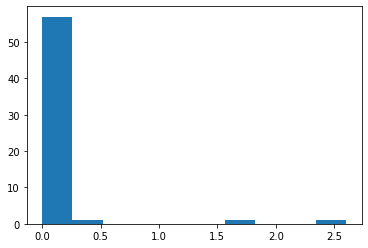

In [262]:
plt.hist(awnp.flatten())

In [263]:
print("l1 gives indices", np.where(np.abs(awnp.flatten()) > 0.1)[0])
print("ground truth indices", sig_item)

l1 gives indices [27 34 42]
ground truth indices [42 27 34]


# Matching pursuit

In [264]:
def scalar_product(D, idx, signal):
    """Find the scalar product between a dictionary item and a signal."""
    return np.dot(D[idx, :], signal)
    
def cos_angle(D, idx, signal):
    """Cos of the angle between dictionary item and the signal."""
    return scalar_product(D, idx, signal) / (1e-10 + np.linalg.norm(signal) * np.linalg.norm(D[idx, :]))
    
def max_scalar_product(D, signal):
    """Find index with maximal scalar product between a dictionary item and the signal."""
    products = [cos_angle(D, idx, signal) for idx in range(len(D))]
#     print(products, np.max(np.abs(products)))
    return np.argmax(np.abs(products))

In [265]:
# current signal
signal_c = np.array(signal)

for _ in range(10):
    idx_max = max_scalar_product(D, signal_c)
    prod_max = scalar_product(D, idx_max, signal_c)
    d_max = D[idx_max, :]
    signal_c -= d_max * prod_max / np.linalg.norm(d_max) ** 2
    print(np.linalg.norm(signal_c), prod_max, idx_max)

11.701313701395001 122.66486247843423 27
2.070619497079887 76.10411880692908 34
0.9598978469684014 13.166653004051819 42
0.2505200097410734 6.522266656253009 27
0.12271756291086287 -1.4432586658471036 34
0.01901864494795665 0.8700453728457896 42
0.004686994452897344 -0.12180240190201463 34
0.00251617582468661 -0.027833363538973144 27
0.0006651168168143807 0.017415114206815907 42
0.0002211821090652002 -0.004145067174208794 34
